In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import time

In [8]:
DATA = "data"

train_data = datasets.CIFAR10(root=DATA, train=True, download=True)
mean = train_data.data.mean(axis=(0, 1, 2)) / 255
std = train_data.data.std(axis=(0, 1, 2)) / 255
print(f"Mean: {mean}, Std: {std}")

100%|██████████| 170498071/170498071 [00:18<00:00, 9010403.42it/s] 


Extracting data\cifar-10-python.tar.gz to data
Mean: [0.49139968 0.48215841 0.44653091], Std: [0.24703223 0.24348513 0.26158784]


In [9]:
train_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [10]:
train_data = datasets.CIFAR10(root=DATA, train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10(root=DATA, train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
VALID_RATE = 0.8
n_train_examples = int(len(train_data) * VALID_RATE)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples])

In [12]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transform

In [13]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 40000
Number of validation examples: 10000
Number of testing examples: 10000


In [14]:
def plot_images(images, labels, classes, normalize=False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min=image_min, max=image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9892129..2.085823].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9892129..2.1267893].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9892129..1.935909].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9892129..1.9658918].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9892129..1.7560123].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9892129..1.8009865].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9892129.

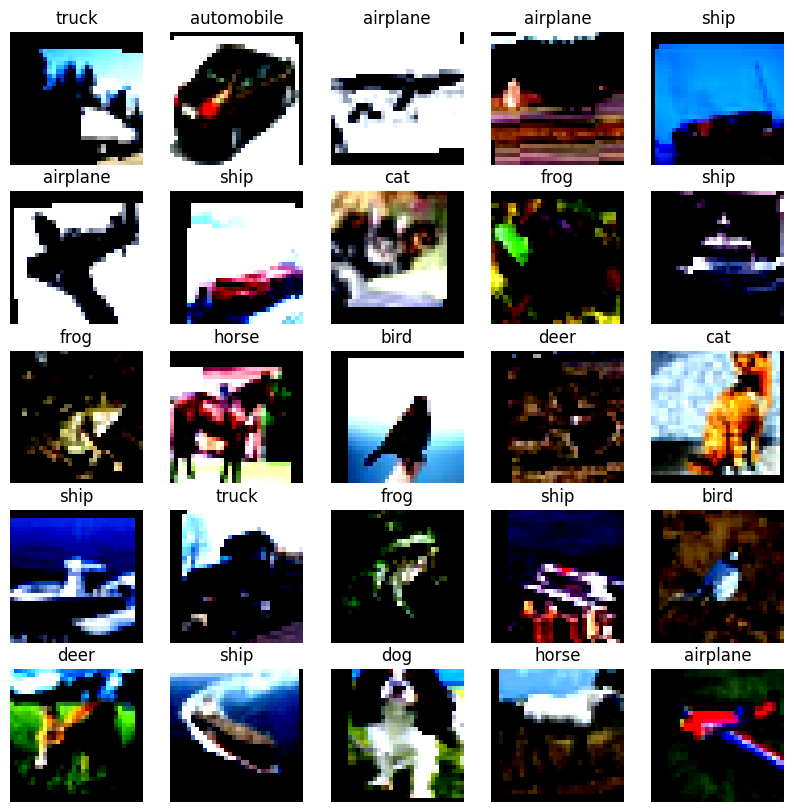

In [15]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in
                       [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

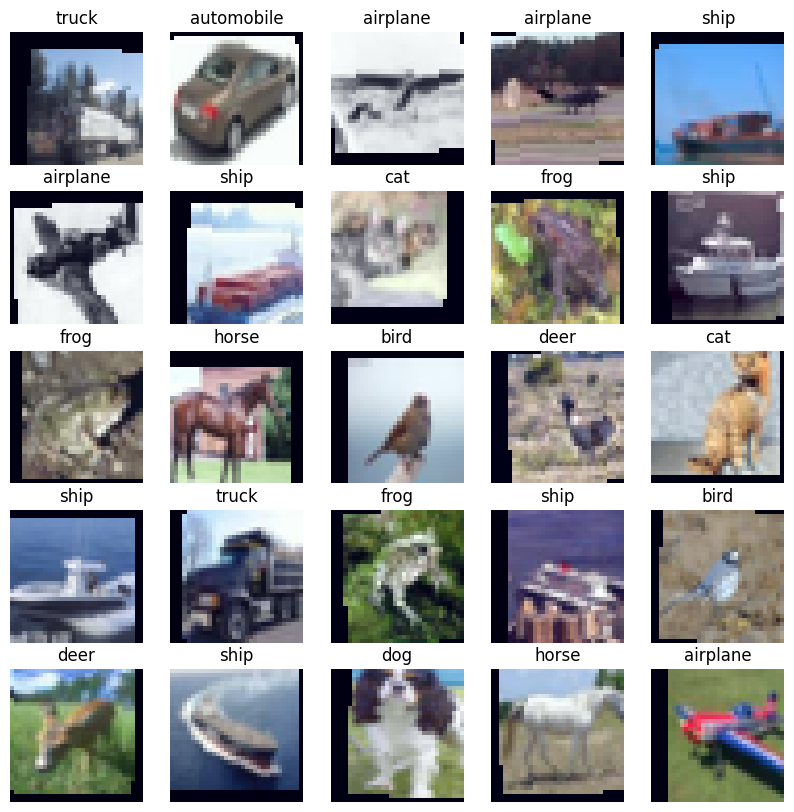

In [16]:
plot_images(images, labels, classes, normalize=True)

In [17]:
BATCH_SIZE = 64

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
      super().__init__()

      self.features = nn.Sequential(
          nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
          nn.MaxPool2d(2),  # kernel_size
          nn.ReLU(inplace=True),
          nn.Conv2d(64, 192, 3, padding=1),
          nn.MaxPool2d(2),
          nn.ReLU(inplace=True),
          nn.Conv2d(192, 384, 3, padding=1),
          nn.ReLU(inplace=True),
          nn.Conv2d(384, 256, 3, padding=1),
          nn.ReLU(inplace=True),
          nn.Conv2d(256, 256, 3, padding=1),
          nn.MaxPool2d(2),
          nn.ReLU(inplace=True)
      )

      self.classifier = nn.Sequential(
          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(256 * 2 * 2, 4096),
          nn.ReLU(inplace=True),
          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(4096, 4096),
          nn.ReLU(inplace=True),
          nn.Linear(4096, output_dim)
      )
    
    def forward(self, x):
      x = self.features(x)
      h = x.view(x.shape[0], -1)
      x = self.classifier(h)
      return x, h

In [19]:
model = AlexNet(10)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,272,266 trainable parameters


In [20]:
def initialize_paramater(m):
  if isinstance(m, nn.Conv2d):
    nn.init.kaiming_uniform_(m.weight.data, nonlinearity="relu")
    nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
    nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain("relu"))
    nn.init.constant_(m.bias.data, 0)

In [21]:
model.apply(initialize_paramater)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [22]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):

        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device

        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr=10, num_iter=100,
                   smooth_f=0.05, diverge_th=5):

        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

        iterator = IteratorWrapper(iterator)

        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            # update lr
            lr_scheduler.step()

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        # reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

        return lrs, losses

    def _train_batch(self, iterator):

        self.model.train()

        self.optimizer.zero_grad()

        x, y = iterator.get_batch()

        x = x.to(self.device)
        y = y.to(self.device)

        y_pred, _ = self.model(x)

        loss = self.criterion(y_pred, y)

        loss.backward()

        self.optimizer.step()

        return loss.item()


class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r
                for base_lr in self.base_lrs]


class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [23]:
START_LR = 1e-7
END_LR = 10
NUM_ITER = 100

optimizer = optim.Adam(model.parameters(), lr=START_LR)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_loader, END_LR, NUM_ITER)

Stopping early, the loss has diverged


C:\Users\hieuh\AppData\Local\Temp\ipykernel_18160\3496258672.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('init_params.pt'))


In [24]:
def plot_lr_finder(lrs, losses, skip_start=5, skip_end=5):

    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

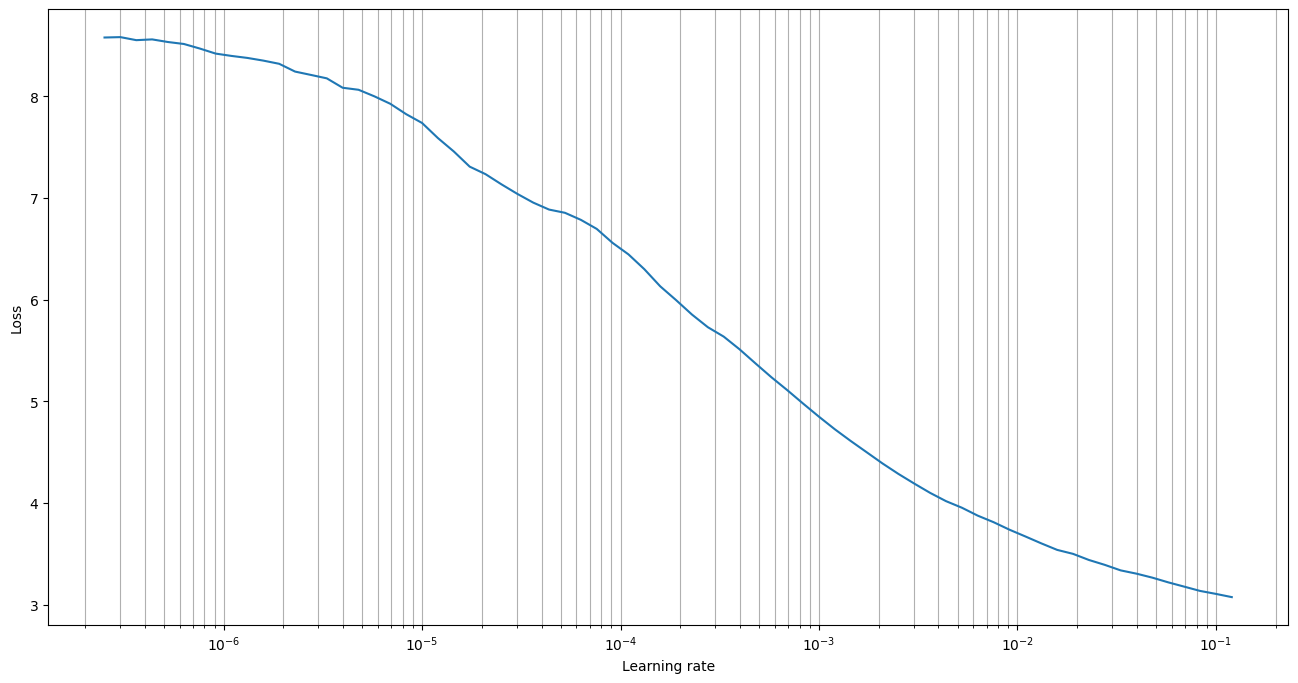

In [25]:
plot_lr_finder(lrs, losses)

In [26]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [27]:
def accuracy(preds, y):
    max_preds = preds.argmax(dim=1, keepdim=True)
    correct = max_preds.squeeze(1).eq(y).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [28]:
def train(model, iterator, optimizer, criterion, device):

  epoch_loss = 0
  epoch_acc = 0

  model.train()
  for (x, y) in tqdm(iterator, desc="Training", leave=False):
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    y_pred, _ = model(x)
    loss = criterion(y_pred, y)
    acc = accuracy(y_pred, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)
    

In [29]:
def evaluate(model, iterator, criterion, device):

  epoch_loss = 0
  epoch_acc = 0

  model.eval()
  with torch.no_grad():
    for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):
      x = x.to(device)
      y = y.to(device)
      y_pred, _ = model(x)
      loss = criterion(y_pred, y)
      acc = accuracy(y_pred, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [35]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time 
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [36]:
EPOCHS = 50
best_valid_loss = float('inf')
for epoch in trange(EPOCHS, desc="Epochs"):
  start_time = time.monotonic()
  train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'AlexNet.pt')
  end_time = time.monotonic()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 20s
	Train Loss: 1.257 | Train Acc: 55.38%
	 Val. Loss: 1.118 |  Val. Acc: 60.08%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 20s
	Train Loss: 1.192 | Train Acc: 58.26%
	 Val. Loss: 1.070 |  Val. Acc: 62.40%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 20s
	Train Loss: 1.143 | Train Acc: 60.14%
	 Val. Loss: 1.041 |  Val. Acc: 63.11%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 19s
	Train Loss: 1.086 | Train Acc: 62.67%
	 Val. Loss: 1.000 |  Val. Acc: 65.47%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 19s
	Train Loss: 1.053 | Train Acc: 63.82%
	 Val. Loss: 0.949 |  Val. Acc: 67.61%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 19s
	Train Loss: 1.025 | Train Acc: 65.16%
	 Val. Loss: 0.958 |  Val. Acc: 66.34%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 19s
	Train Loss: 0.991 | Train Acc: 66.19%
	 Val. Loss: 0.937 |  Val. Acc: 67.57%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 19s
	Train Loss: 0.974 | Train Acc: 67.03%
	 Val. Loss: 0.957 |  Val. Acc: 67.67%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 19s
	Train Loss: 0.950 | Train Acc: 67.84%
	 Val. Loss: 0.939 |  Val. Acc: 68.11%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 19s
	Train Loss: 0.931 | Train Acc: 68.48%
	 Val. Loss: 0.892 |  Val. Acc: 69.59%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 19s
	Train Loss: 0.908 | Train Acc: 69.05%
	 Val. Loss: 0.891 |  Val. Acc: 69.07%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 31s
	Train Loss: 0.897 | Train Acc: 69.63%
	 Val. Loss: 0.872 |  Val. Acc: 70.55%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 26s
	Train Loss: 0.884 | Train Acc: 70.30%
	 Val. Loss: 0.861 |  Val. Acc: 70.42%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 19s
	Train Loss: 0.878 | Train Acc: 70.58%
	 Val. Loss: 0.837 |  Val. Acc: 70.98%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 20s
	Train Loss: 0.857 | Train Acc: 71.23%
	 Val. Loss: 0.829 |  Val. Acc: 72.24%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 19s
	Train Loss: 0.852 | Train Acc: 71.43%
	 Val. Loss: 0.812 |  Val. Acc: 72.44%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 19s
	Train Loss: 0.830 | Train Acc: 72.05%
	 Val. Loss: 0.814 |  Val. Acc: 73.12%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 19s
	Train Loss: 0.833 | Train Acc: 71.91%
	 Val. Loss: 0.827 |  Val. Acc: 71.87%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 19s
	Train Loss: 0.817 | Train Acc: 72.50%
	 Val. Loss: 0.797 |  Val. Acc: 73.17%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 19s
	Train Loss: 0.812 | Train Acc: 72.78%
	 Val. Loss: 0.769 |  Val. Acc: 74.07%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 0m 19s
	Train Loss: 0.799 | Train Acc: 73.28%
	 Val. Loss: 0.785 |  Val. Acc: 74.65%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 0m 19s
	Train Loss: 0.789 | Train Acc: 73.64%
	 Val. Loss: 0.789 |  Val. Acc: 73.82%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 0m 19s
	Train Loss: 0.782 | Train Acc: 73.80%
	 Val. Loss: 0.756 |  Val. Acc: 74.94%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 0m 19s
	Train Loss: 0.773 | Train Acc: 74.17%
	 Val. Loss: 0.766 |  Val. Acc: 74.09%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 0m 19s
	Train Loss: 0.768 | Train Acc: 74.46%
	 Val. Loss: 0.756 |  Val. Acc: 74.86%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 0m 19s
	Train Loss: 0.759 | Train Acc: 74.87%
	 Val. Loss: 0.761 |  Val. Acc: 75.16%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: 0m 19s
	Train Loss: 0.759 | Train Acc: 74.71%
	 Val. Loss: 0.750 |  Val. Acc: 75.25%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 0m 19s
	Train Loss: 0.748 | Train Acc: 74.94%
	 Val. Loss: 0.773 |  Val. Acc: 74.41%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 29 | Epoch Time: 0m 19s
	Train Loss: 0.746 | Train Acc: 75.29%
	 Val. Loss: 0.756 |  Val. Acc: 75.01%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 0m 19s
	Train Loss: 0.743 | Train Acc: 75.34%
	 Val. Loss: 0.738 |  Val. Acc: 75.41%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 31 | Epoch Time: 0m 19s
	Train Loss: 0.735 | Train Acc: 75.65%
	 Val. Loss: 0.747 |  Val. Acc: 75.06%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 32 | Epoch Time: 0m 19s
	Train Loss: 0.729 | Train Acc: 75.59%
	 Val. Loss: 0.717 |  Val. Acc: 76.17%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 33 | Epoch Time: 0m 19s
	Train Loss: 0.722 | Train Acc: 76.21%
	 Val. Loss: 0.720 |  Val. Acc: 76.24%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 34 | Epoch Time: 0m 19s
	Train Loss: 0.723 | Train Acc: 76.37%
	 Val. Loss: 0.762 |  Val. Acc: 75.30%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 35 | Epoch Time: 0m 19s
	Train Loss: 0.703 | Train Acc: 76.65%
	 Val. Loss: 0.714 |  Val. Acc: 76.40%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 36 | Epoch Time: 0m 19s
	Train Loss: 0.704 | Train Acc: 76.87%
	 Val. Loss: 0.716 |  Val. Acc: 76.59%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 37 | Epoch Time: 0m 19s
	Train Loss: 0.698 | Train Acc: 77.06%
	 Val. Loss: 0.762 |  Val. Acc: 74.71%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 38 | Epoch Time: 0m 19s
	Train Loss: 0.705 | Train Acc: 76.65%
	 Val. Loss: 0.721 |  Val. Acc: 75.95%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 39 | Epoch Time: 0m 19s
	Train Loss: 0.687 | Train Acc: 77.23%
	 Val. Loss: 0.739 |  Val. Acc: 75.89%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 40 | Epoch Time: 0m 19s
	Train Loss: 0.692 | Train Acc: 77.19%
	 Val. Loss: 0.771 |  Val. Acc: 74.69%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 41 | Epoch Time: 0m 19s
	Train Loss: 0.700 | Train Acc: 77.19%
	 Val. Loss: 0.734 |  Val. Acc: 76.14%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 42 | Epoch Time: 0m 19s
	Train Loss: 0.687 | Train Acc: 77.50%
	 Val. Loss: 0.721 |  Val. Acc: 76.70%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 43 | Epoch Time: 0m 19s
	Train Loss: 0.695 | Train Acc: 77.07%
	 Val. Loss: 0.707 |  Val. Acc: 77.23%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 44 | Epoch Time: 0m 19s
	Train Loss: 0.691 | Train Acc: 77.55%
	 Val. Loss: 0.715 |  Val. Acc: 76.38%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 45 | Epoch Time: 0m 19s
	Train Loss: 0.674 | Train Acc: 77.96%
	 Val. Loss: 0.708 |  Val. Acc: 76.82%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 46 | Epoch Time: 0m 19s
	Train Loss: 0.678 | Train Acc: 77.84%
	 Val. Loss: 0.722 |  Val. Acc: 75.81%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 47 | Epoch Time: 0m 19s
	Train Loss: 0.676 | Train Acc: 77.62%
	 Val. Loss: 0.732 |  Val. Acc: 76.42%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 48 | Epoch Time: 0m 19s
	Train Loss: 0.668 | Train Acc: 78.21%
	 Val. Loss: 0.765 |  Val. Acc: 74.23%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 49 | Epoch Time: 0m 19s
	Train Loss: 0.678 | Train Acc: 77.60%
	 Val. Loss: 0.721 |  Val. Acc: 75.70%


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 50 | Epoch Time: 0m 19s
	Train Loss: 0.668 | Train Acc: 78.22%
	 Val. Loss: 0.723 |  Val. Acc: 76.26%


In [38]:
model.load_state_dict(torch.load('AlexNet.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

C:\Users\hieuh\AppData\Local\Temp\ipykernel_18160\3904030244.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('AlexNet.pt'))


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.716 | Test Acc: 76.60%


In [40]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

images, labels, probs = get_predictions(model, test_loader, device)
pred_labels = torch.argmax(probs, 1)


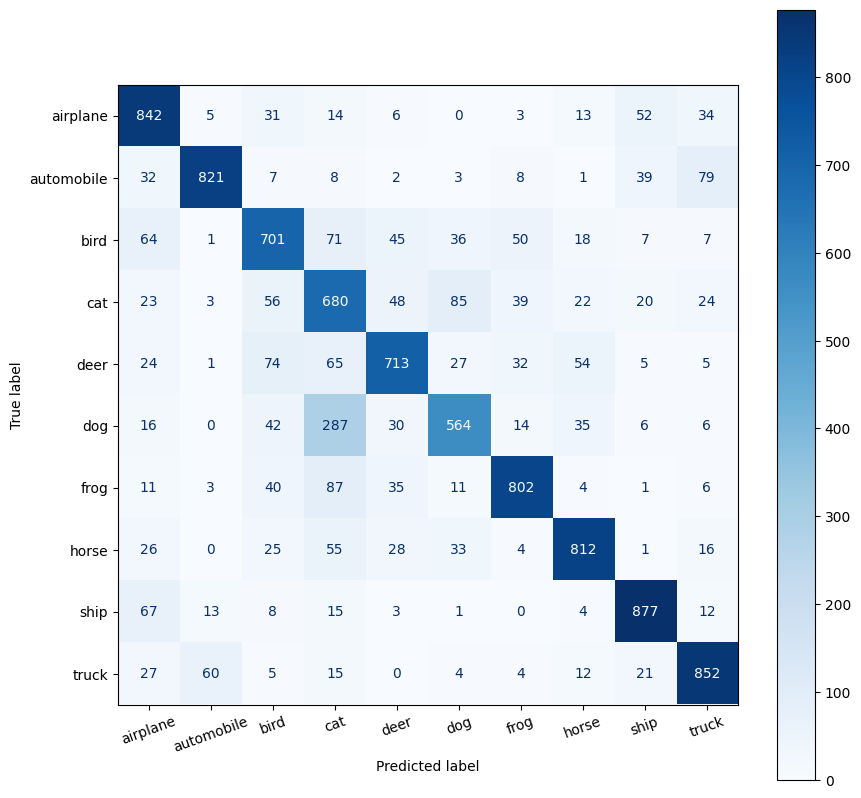

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20)

plot_confusion_matrix(labels, pred_labels, classes)